In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}
// Avoid scrollable output for many plots

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import datetime
import numpy as np
import seaborn as sns; sns.set(font_scale=1.5)
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy.stats import randint
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pandas.set_option("display.precision", 8)
timestamp = datetime.datetime.now().strftime("%Y-%b-%d")

# Load the data

In [3]:
df = pd.read_parquet('data_2018-Oct-25.parquet')
print('Number cars: {}'.format(df.shape[0]));
df.head()

Number cars: 490


,headline,year,odometer,price,description,horsepower,region,transmissionManual,fuelTypeGasoline,carTypeStationCar,engineSize,trim
0,"Skoda Fabia 1,4 TDi 105 Ambition Combi 5d",2016,45000.0,149123.0,"Alu., Fuldaut. Klima, Fjernb. C.Lås, Parkering...",105.0,Syd- og Vestsjælland,True,False,True,"1,4",Ambition
1,"Skoda Fabia 1,2 TSi 90 Style Combi 5d",2016,55000.0,149800.0,Udvidet Fabriks Garanti Til 04-03-2020 Dog Mak...,90.0,Syd- og Vestsjælland,True,True,True,"1,2",Style
2,"Skoda Fabia 1,2 TSi 110 Style Combi 5d",2015,49000.0,149900.0,Udvidet Garanti Frem Til 6/2020 Eller 100.000 ...,110.0,Østjylland,True,True,True,"1,2",Style
3,"Skoda Fabia 1,4 16V 75 Ambiente Combi 5d",2005,131000.0,44900.0,"Airc., Træk, Fartpilot, Sædevarme, Kørecompute...",75.0,København,True,True,True,"1,4",Ambiente
4,"Skoda Fabia 1,2 TSi 90 Active 5d",2016,34000.0,134990.0,+++ 2016 MODEL Active ++ LAVT KM TAL | Aft. T...,90.0,Syd- og Sønderjylland,True,True,False,"1,2",Active


In [4]:
df.describe()

,year,odometer,price,horsepower
count,490.000000,490.000000,490.000000,490.000000
mean,2011.475510,116578.279592,87660.485714,87.828571
std,4.645777,85607.792034,52973.696961,14.614025
min,2000.000000,1000.000000,4999.000000,54.000000
25%,2008.000000,39000.000000,42600.000000,75.000000
50%,2011.000000,105000.000000,74850.000000,86.000000
75%,2016.000000,176000.000000,143780.000000,101.000000
max,2019.000000,443000.000000,207800.000000,110.000000


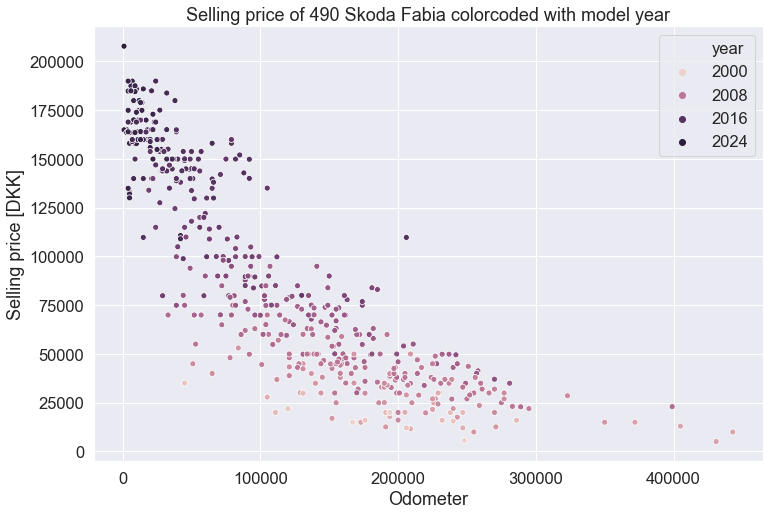

In [5]:
plt.rcParams["figure.figsize"] =(12,8)
ax = sns.scatterplot(x="odometer", y="price", hue="year", data=df)
ax.set_ylabel('Selling price [DKK]');
ax.set_xlabel('Odometer');
ax.set_title(f'Selling price of {df.shape[0]} Skoda Fabia colorcoded with model year');

# Prepare data for modelling

In [6]:
features_raw = df.drop(['description', 'headline'], axis=1)
features_raw = pd.get_dummies(features_raw)
features_raw.head()

,year,odometer,price,horsepower,transmissionManual,fuelTypeGasoline,carTypeStationCar,region_Fyn,region_København,region_Lolland-Falster,...,trim_Classic,trim_Comfort,trim_Elegance,trim_Family,trim_Fresh,trim_Greenline,trim_Sport,trim_Style,trim_Tour de France,trim_VM Edition
0,2016,45000.0,149123.0,105.0,True,False,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016,55000.0,149800.0,90.0,True,True,True,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2015,49000.0,149900.0,110.0,True,True,True,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2005,131000.0,44900.0,75.0,True,True,True,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2016,34000.0,134990.0,90.0,True,True,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Labels are the values we want to predict, often also called y
labels = np.array(features_raw['price'])

# Remove the labels from the features, often also called X
features = features_raw.drop('price', axis=1)

# Saving feature names for later use
feature_list = features.columns.tolist()

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# Train the model

In [8]:
# Instantiate model with X decision trees
model_rf = RandomForestRegressor() # Baseline values

# Train the model on training data
model_rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Evaluate the model

In [9]:
# Compare the true HP values with the predicted
true_price = test_labels
pred_price = model_rf.predict(test_features)

df_out = pd.DataFrame({'True price': true_price, 'Predicted price': pred_price})
df_out['Error'] = df_out['Predicted price'] - df_out['True price']
df_out['absError'] = np.abs(df_out['Predicted price'] - df_out['True price'])

Model:                    Baseline
Mean absolute error:      6628.09
Median absolute error:    5094.00
R2 score:                   97.35%



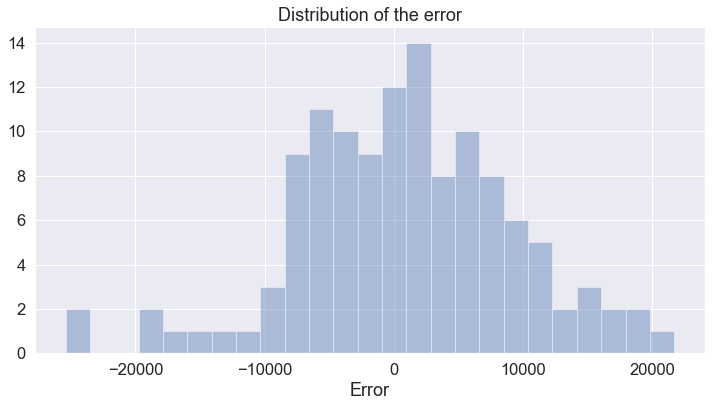

In [10]:
def print_model_metrics(name, model):
    pred_labels = model.predict(test_features)
    print(f'Model:                    {name}')
    print(f'Mean absolute error:      {mean_absolute_error(test_labels, pred_labels):7.2f}')
    print(f'Median absolute error:    {median_absolute_error(test_labels, pred_labels):7.2f}')
    print(f'R2 score:                 {r2_score(test_labels, pred_labels):8.2%}')
    print()

print_model_metrics('Baseline', model_rf)    
# Visualize distribution of the error
plt.rcParams["figure.figsize"] =(12,6)
ax = sns.distplot(df_out['Error'], kde=False, bins=25);
ax.set_title('Distribution of the error');

In [11]:
# The 5 worst predictions
df_out.sort_values('absError', ascending=False).head()

,True price,Predicted price,Error,absError
55,207800.0,182380.0,-25420.0,25420.0
24,49900.0,24986.0,-24914.0,24914.0
19,85000.0,106721.0,21721.0,21721.0
15,159900.0,179560.0,19660.0,19660.0
110,83000.0,63574.0,-19426.0,19426.0


In [12]:
# The 5 best predictions
df_out.sort_values('absError', ascending=True).head(5)

,True price,Predicted price,Error,absError
46,143780.0,143780.0,0.0,0.0
54,143780.0,143780.0,0.0,0.0
64,143780.0,143780.0,0.0,0.0
105,149900.0,149900.0,0.0,0.0
97,163500.0,163538.0,38.0,38.0


# Tune the hyper parameters

In [13]:
# Initial values
#RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#           max_features='auto', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=1, min_samples_split=2,
#           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
#           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Define the search space
parameter_grid = {
    #'n_estimators': [10,100,1000,10000],
    #'max_depth': [None] + [int(x) for x in np.linspace(1, 150,16)],
    #'min_samples_split': [2,3,4,5,6,7,8,9,10],
    #'min_samples_leaf': [1,2,3,4,5,7,8,9,10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    
    # Select for subspace search
    'min_samples_split': [4],
    'n_estimators': [1000],
    'max_depth': [40],
    
}

# Now test n_iter randomly select parameter combinations 
# Use RandomizedSearchCV for explorative search and GridSearchCV for detailed search 

# Use this for sampling a large parameter space
#search_model=RandomizedSearchCV(
#   n_iter=10, 
#    cv=3, 
#    verbose=3, 
#    estimator=RandomForestRegressor(), 
#    param_distributions=parameter_grid, 
#    #random_state=42, 
#    n_jobs = -1
#)

# Use this for at search of a smaller subspace
search_model=GridSearchCV(
    cv=10, 
    verbose=2, 
    estimator=RandomForestRegressor(), 
    param_grid=parameter_grid, 
    n_jobs=-1
)

# Fit the random search model
search_model.fit(train_features, train_labels)

# Tuning Results
df_scores = pd.DataFrame(search_model.cv_results_).sort_values(by='rank_test_score')
tuned_params = search_model.best_params_
print(f'Best score:      {search_model.best_score_:.4f}')
print(f'Best parameters: {tuned_params}')
df_scores.head()

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.5s finished


Best score:      0.9725
Best parameters: {'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.481106,0.184863,0.098912,0.040789,40,auto,4,1000,"{'max_depth': 40, 'max_features': 'auto', 'min...",0.970107,...,0.994734,0.994779,0.994966,0.994929,0.995027,0.995137,0.995056,0.994461,0.994869,0.000201
3,1.145326,0.134576,0.052081,0.009085,40,None,4,1000,"{'max_depth': 40, 'max_features': None, 'min_s...",0.969685,...,0.994731,0.994743,0.994919,0.994944,0.995074,0.995106,0.995064,0.994433,0.994828,0.000218
1,1.001773,0.140631,0.087261,0.057197,40,sqrt,4,1000,"{'max_depth': 40, 'max_features': 'sqrt', 'min...",0.967695,...,0.990239,0.991016,0.990611,0.990598,0.990362,0.990629,0.990603,0.989692,0.990405,0.000352
2,0.908263,0.143654,0.056031,0.019569,40,log2,4,1000,"{'max_depth': 40, 'max_features': 'log2', 'min...",0.967510,...,0.990135,0.991004,0.990536,0.990292,0.990507,0.990735,0.990346,0.989632,0.990349,0.000370


# Compare baseline model vs tuned model

In [14]:
# Instantiate model with X decision trees
model_rf_tuned = RandomForestRegressor(**tuned_params)

# Train the tuned model on training data
model_rf_tuned.fit(train_features, train_labels)

# Selected model
model_selected = RandomForestRegressor(
    n_estimators=5000,
    max_depth=40,
    max_features='auto', 
    max_leaf_nodes=100,
    min_samples_leaf=1,
    min_samples_split=2,    
)

# Train the tuned model on training data
model_selected.fit(train_features, train_labels)

print_model_metrics('Baseline', model_rf)  
print_model_metrics('Tuned model', model_rf_tuned)  
print_model_metrics('Selected model', model_selected)                  

Model:                    Baseline
Mean absolute error:      6628.09
Median absolute error:    5094.00
R2 score:                   97.35%

Model:                    Tuned model
Mean absolute error:      5996.66
Median absolute error:    4174.84
R2 score:                   97.58%

Model:                    Selected model
Mean absolute error:      6064.14
Median absolute error:    4365.44
R2 score:                   97.59%



# Feature importance

Variable: year                      Importance: 0.8808
Variable: odometer                  Importance: 0.0547
Variable: horsepower                Importance: 0.0481


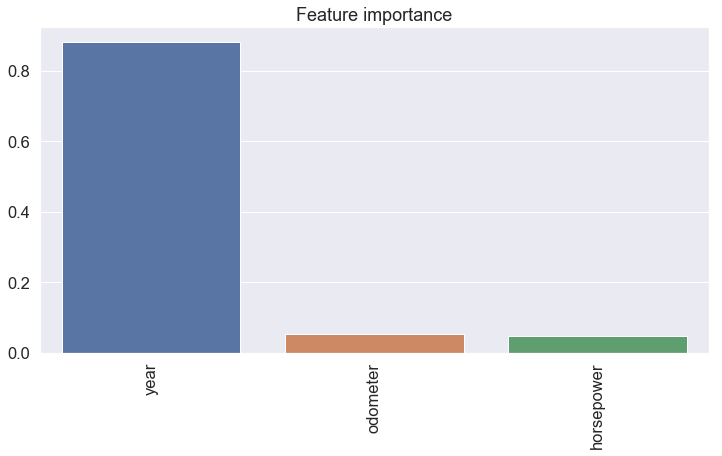

In [15]:
# Get numerical feature importances
importances = model_selected.feature_importances_.tolist()

# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print out the feature and importances
[print(f'Variable: {f:25} Importance: {i:.4f}') for f,i in feature_importances if i > 0.01];

plt.rcParams["figure.figsize"] =(12,6)
_feature    = [f for f,i in feature_importances if i > 0.01]
_importance = [i for f,i in feature_importances if i > 0.01]
ax = sns.barplot(x=_feature, y=_importance)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
ax.set_title('Feature importance');

# Explain a prediction

In [16]:
categorical_features = np.argwhere(np.array([len(set(features[:,x])) for x in range(features.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train_features,
        feature_names=feature_list,
        class_names=['price'],
        categorical_features=categorical_features,
        mode='regression')

In [17]:
# Take a random example and inspect how it is priced
i=17
print(f'Sales price:     {test_labels[i]:6.0f}')
print(f'Predicted price: {model_selected.predict(test_features)[i]:6.0f}')
print(f'Difference:      {model_selected.predict(test_features)[i]-test_labels[i]:6.0f}')
print()

for k,j in enumerate(test_features[i]):
    if j:
        print(f'{feature_list[k]:20} = {j}')

exp = explainer.explain_instance(test_features[i], model_selected.predict, num_features=6)
exp.show_in_notebook(show_table=True)

Sales price:     149780
Predicted price: 148150
Difference:       -1630

year                 = 2016
odometer             = 33000.0
horsepower           = 90.0
transmissionManual   = True
fuelTypeGasoline     = True
carTypeStationCar    = True
region_Østjylland    = 1
engineSize_1,2       = 1
trim_Ambition        = 1


In [18]:
# Now use the model to evaluate my car

#for k,j in enumerate(test_features[i].tolist()):
#    print(k, feature_list[k], j)

test_car = np.array([2017, 24500, 110, 0, 1, 1,
       0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0,
       1, 0, 0])

for k,j in enumerate(test_car):
    if j:
        print(f'{feature_list[k]:20} = {j}')
    
exp = explainer.explain_instance(test_car, model_selected.predict, num_features=6)
exp.show_in_notebook(show_table=True)

year                 = 2017
odometer             = 24500
horsepower           = 110
fuelTypeGasoline     = 1
carTypeStationCar    = 1
region_København     = 1
engineSize_1,2       = 1
trim_Style           = 1
